In [33]:
import pandas as pd

In [34]:
acc_names = ['ax', 'ay', 'az']
rate_gyro_names = ['gx', 'gy', 'gz']
lab_1_positions = ["Laying_down", "Standing_up", "Walking"]
sensors = ["Accelerometer", "Gyroscope"]

# Helper functions

In [35]:
def get_paths_based_on(positions: list[str], set_name: str) -> list[list[str]]:
    return [
        [f"../Binaries/{set_name}/{pos}-1.pkl", f"../Binaries/{set_name}/{pos}-2.pkl"]
        for pos in positions
    ]

# Data analysis

In [36]:
def read_csv(filename: str, names: list[str]) -> pd.DataFrame:
    return pd.read_csv(filename, usecols=[1, 2, 3], names=names, skiprows=[0])

In [37]:
def read_recordings(positions: list[str] = lab_1_positions) -> dict[str:pd.DataFrame]:
    recordings = {}

    for position in positions:
        for i in range(1, 4):
            for sensor in sensors:
                dataframe = (
                    read_csv(f"../Data/ML_Lab_1_{position}_{i}/{sensor}.csv", names=acc_names
                    if sensor == "Accelerometer"
                    else rate_gyro_names)
                )
                recordings[f"{position} {sensor} {i}"] = dataframe

    return recordings
        

##### Plot the accelerometer values using the plot functions accessible for panda dataframes. Plot all accelerometer values, i.e. all samples for all components of the accelerometer vector.

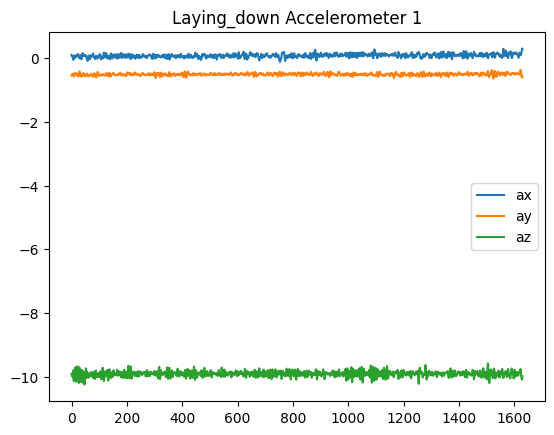

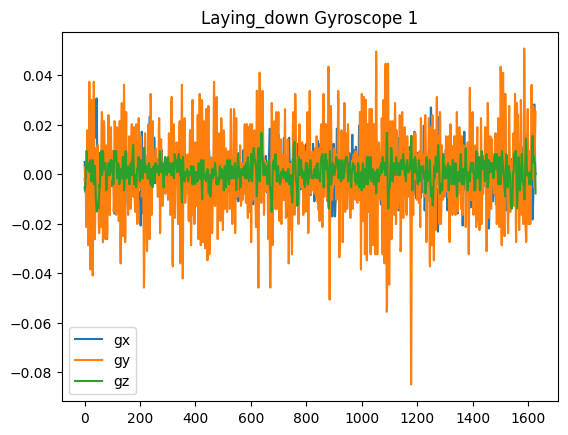

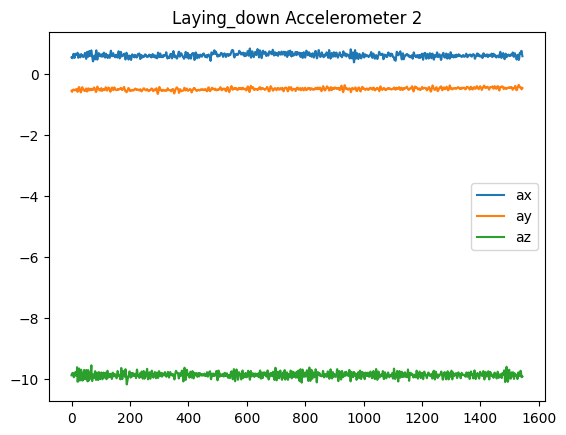

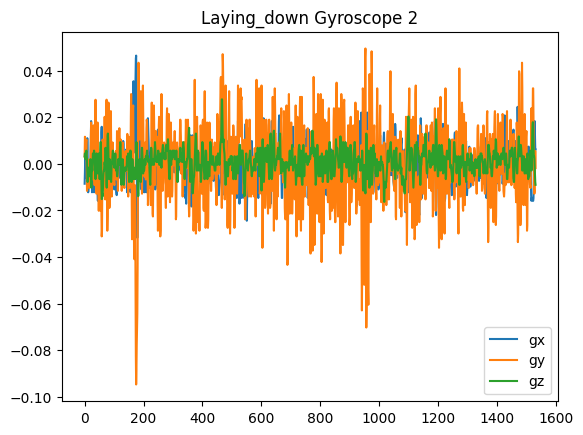

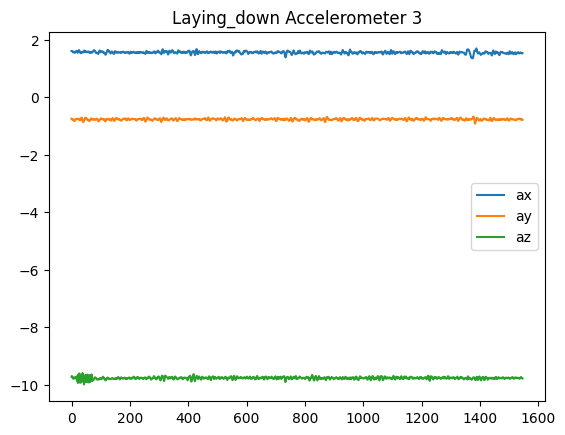

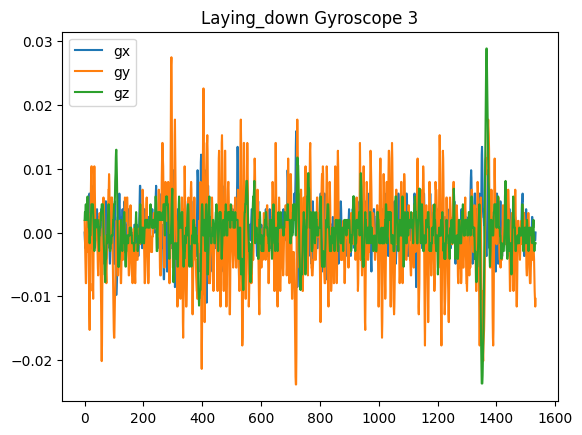

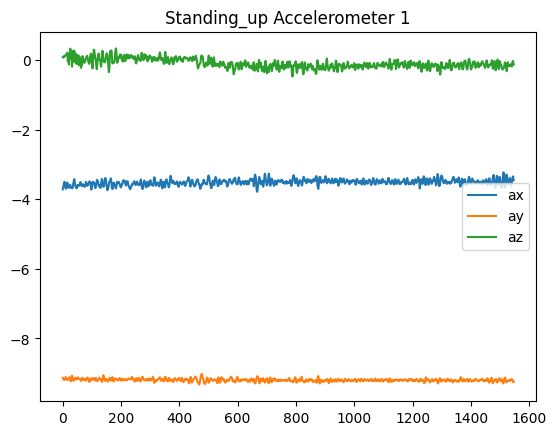

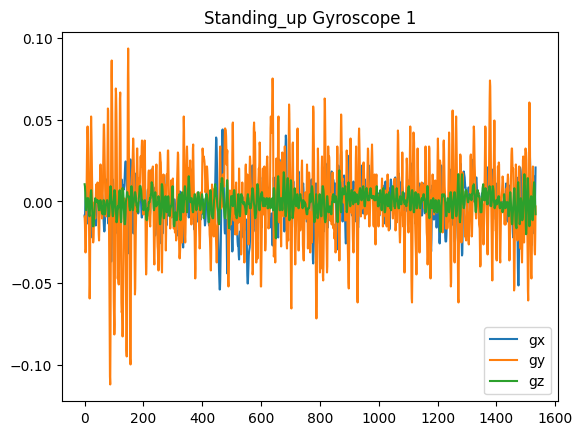

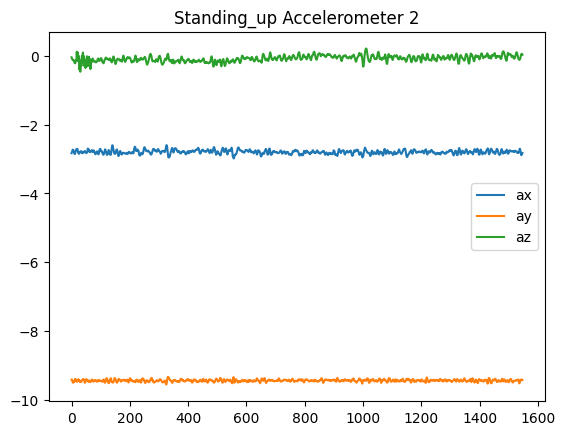

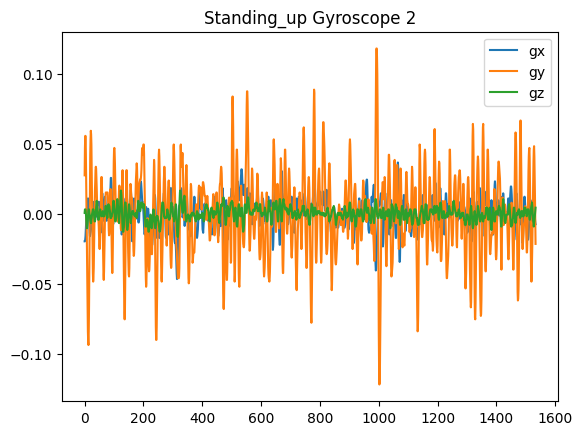

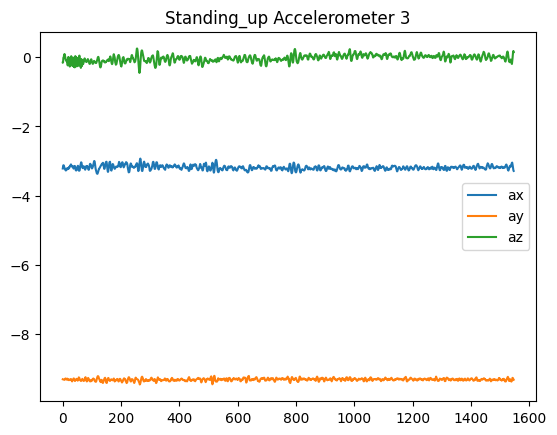

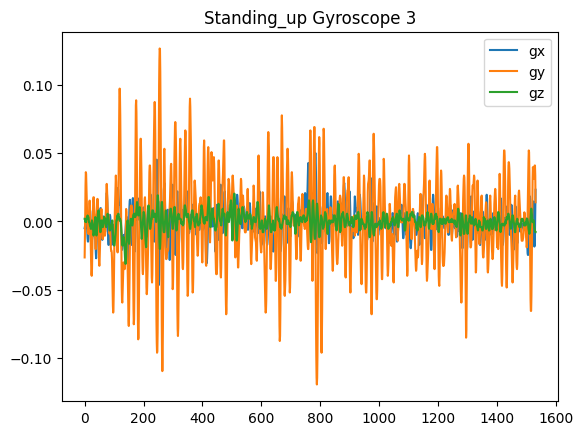

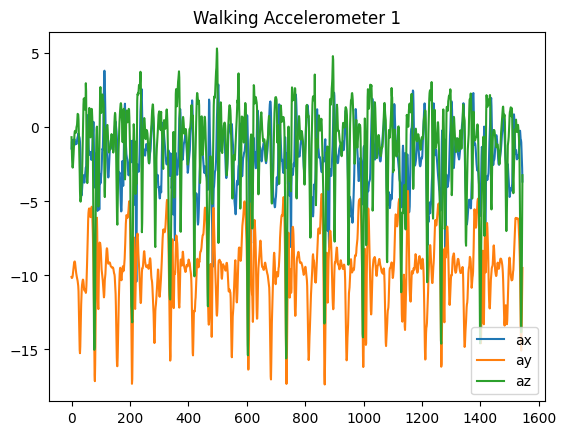

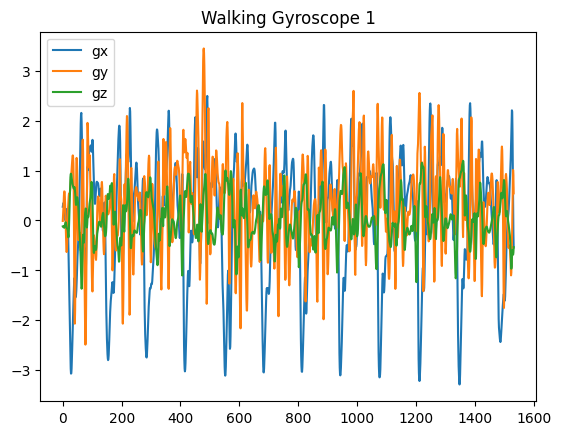

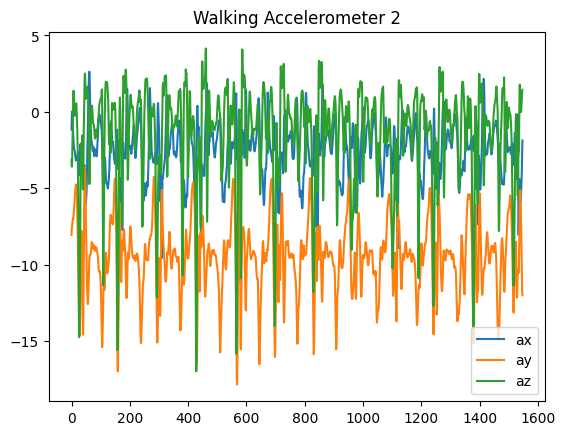

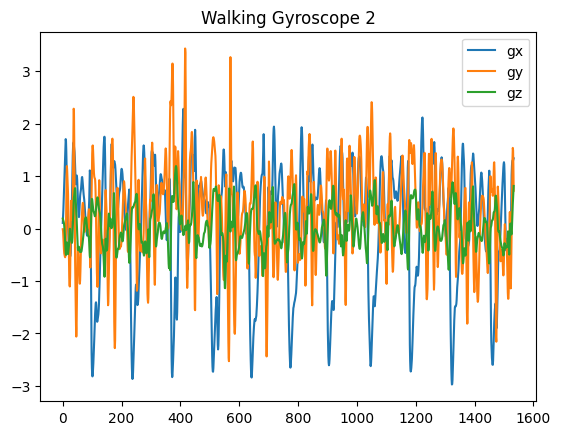

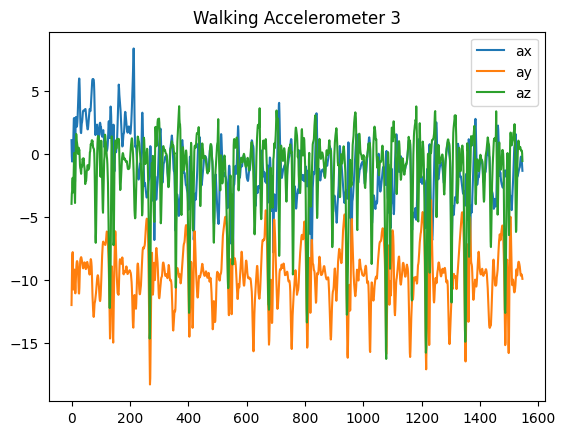

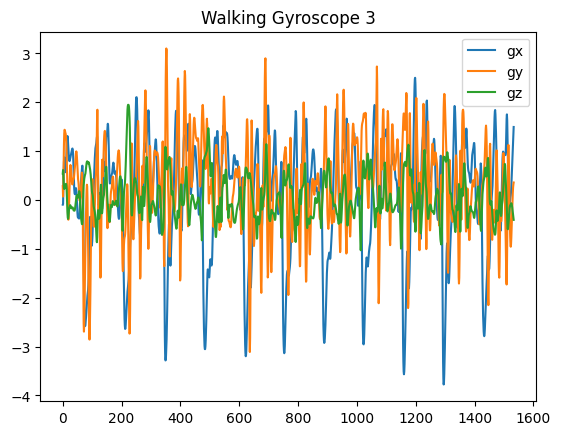

In [38]:
raw_dfs = read_recordings()

for key in raw_dfs:
    raw_dfs[key].plot(title=key)

##### What are we measuring with the accelerometer and rate_gyro?
The Accelerometer measures the rotation of the device. Hence, we can determine the orientation of the device.
In Laying down position, the z-axis reports -9.8m/s^2, hence the screen-side of the phone is pointing down. The z-axis pointing out of the screen is negative. 

Note: Walking includes turning.

Gyroscope measures the angular acceleration in each axis.

# Preprocessing the data
#### Once again plot the data for each recording. You should see some irregular data in the beginning of the recording and in the end of the recording.

##### Why do you have these irregularities in your recordings? Or maybe you do not, how come?
Collected the data with the 7 seconds delay in the beginning to get in position.

##### Create a python function that can read one accelerometer file and one rategyro file, remove a specific number of samples in the beginning and in the end and output a dataframe with six columns, that is all the accelerometer and rateygyro attributes. What do you need as input to the function?

In [39]:
def pre_process_file(acc_file: str, rate_gyro_file: str, n: int) -> pd.DataFrame:
    acc_frame = read_csv(acc_file, acc_names)
    rate_gyro_frame = read_csv(rate_gyro_file, rate_gyro_names)

    acc_frame.drop(acc_frame.head(n).add(acc_frame.tail(n)).index, inplace=True)
    rate_gyro_frame.drop(rate_gyro_frame.head(n).add(rate_gyro_frame.tail(n)).index, inplace=True)

    return (pd
            .concat([acc_frame, rate_gyro_frame], axis='columns', ignore_index=True)
            .rename({index: label for index, label in enumerate(acc_names + rate_gyro_names)}, axis='columns')
            .dropna(how='any'))

##### Calls pre_process_file() for all accelerometer and rate_gyro csv's for each class/position

In [40]:
def merger(remove_n: int, positions: list[str] = lab_1_positions) -> dict[str:pd.DataFrame]:
    dfs = {}

    for pos in positions:
        for x in range(1, 4):
            processed_dataframe = pre_process_file(acc_file=f"../Data/ML_Lab_1_{pos}_{x}/Accelerometer.csv",
                                                   rate_gyro_file=f"../Data/ML_Lab_1_{pos}_{x}/Gyroscope.csv",
                                                   n=remove_n)
            dfs[f"{pos}-{x}"] = processed_dataframe

    return dfs

In [41]:
pre_processed_dataframes = merger(remove_n=3)

##### Processed dataframes

In [42]:
for i in pre_processed_dataframes:
    print(f"{i}\n{pre_processed_dataframes[i]}")

Laying_down-1
            ax        ay         az        gx        gy        gz
3     0.066700 -0.497707  -9.903594 -0.007330  0.003054 -0.004123
4     0.021236 -0.492921  -9.970892 -0.007330 -0.001833 -0.000458
5    -0.007478 -0.500100 -10.028319 -0.004887 -0.015271  0.003207
6    -0.019442 -0.512064  -9.822238 -0.002443 -0.021380  0.006872
7    -0.050548 -0.524028  -9.800702 -0.000000 -0.007941  0.009315
...        ...       ...        ...       ...       ...       ...
1620  0.150449 -0.464208  -9.843773  0.002443  0.018936  0.006872
1621  0.100199 -0.411565  -9.800702  0.019547  0.003054  0.006872
1622  0.090628 -0.368495  -9.762417  0.028099 -0.005498  0.004429
1623  0.095414 -0.390030  -9.819845  0.028099 -0.003054  0.004429
1624  0.124128 -0.435494  -9.920643  0.018325  0.005498  0.004429

[1622 rows x 6 columns]
Laying_down-2
            ax        ay         az        gx        gy        gz
3     0.507278 -0.564706  -9.831809  0.007330  0.004276  0.001985
4     0.543171 -0.53838

# Python
#### Store each dataframe, one for each recording, in a binary file using the to_pickle function, and divide the data into two sets, training set and test set. Store 2 of 3 files in the training folder and 1 of 3 files in the test folder. Note: it is the binary pickle files we talk about

In [43]:
def split_train_test_sets(processed_dataframes: dict[str:pd.DataFrame]):
    for i in processed_dataframes:
        if i.__contains__("-1") or i.__contains__("-2"):
            processed_dataframes[i].to_pickle(f"../Binaries/Training/{i}.pkl")

        else:
            processed_dataframes[i].to_pickle(f"../Binaries/Test/{i}.pkl")

In [44]:
split_train_test_sets(pre_processed_dataframes)

##### Create a python function that can read all binary-files from one class. The function should return a dataframe x with all the data and also a column with information of which class the data belongs to. The dataframe has now 7 columns.

##### Note: Only applied to the training set

In [45]:
def merge_measurements_by_class(
        recordings: list[str],
        class_name: str,
        store_as_pickle: bool = False,
        directory: str = "../Binaries/Class dataframes/"
) -> pd.DataFrame:
    
    df = pd.concat(list(map(lambda i: pd.read_pickle(i), recordings)), axis='rows', ignore_index=True)
    df['class'] = class_name

    if store_as_pickle:
        df.to_pickle(directory + df['class'][0] + ".pkl")

    return df

##### Merge the training set into three dataframes (one for each class) and store it as a pickle file

In [46]:
def merge_recordings_by_rows(classes : list[str], set_name: str = 'Training') -> list[pd.DataFrame]:
    paths = get_paths_based_on(positions=classes, set_name=set_name)
    return [
        merge_measurements_by_class(
            recordings=_class,
            class_name=_class[0].replace(f"../Binaries/{set_name}/", "").replace("-1.pkl", "").replace("-2.pkl", ""),
            store_as_pickle=True)

        for _class in paths
    ]

In [47]:
class_dfs = merge_recordings_by_rows(lab_1_positions)

##### Display the three classes

In [48]:
print(*class_dfs, sep='\n')

            ax        ay         az        gx        gy        gz        class
0     0.066700 -0.497707  -9.903594 -0.007330  0.003054 -0.004123  Laying_down
1     0.021236 -0.492921  -9.970892 -0.007330 -0.001833 -0.000458  Laying_down
2    -0.007478 -0.500100 -10.028319 -0.004887 -0.015271  0.003207  Laying_down
3    -0.019442 -0.512064  -9.822238 -0.002443 -0.021380  0.006872  Laying_down
4    -0.050548 -0.524028  -9.800702 -0.000000 -0.007941  0.009315  Laying_down
...        ...       ...        ...       ...       ...       ...          ...
3144  0.485743 -0.533599  -9.932607 -0.014660  0.020158  0.006872  Laying_down
3145  0.519243 -0.528814  -9.973285 -0.006108  0.001833  0.003207  Laying_down
3146  0.571885 -0.473779 -10.018748  0.008552 -0.010384  0.003207  Laying_down
3147  0.593420 -0.445065  -9.975677  0.018325 -0.012828  0.001985  Laying_down
3148  0.622134 -0.416351  -9.886844  0.018325 -0.011606 -0.001680  Laying_down

[3149 rows x 7 columns]
            ax        ay   